In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

# import plotting stuff
from utils.plot_utils import *

# import data loading stuff
from utils.data_utils import load_movement_df

In [5]:
path_to_data = os.path.join('..', 'data')
movement_df, ward2cluster = load_movement_df(path_to_data, True)

date_min         = pd.to_datetime("2020-02-01")
date_max         = pd.to_datetime("2021-02-28")
dates_simulation = pd.date_range(start=date_min, end=date_max)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_25696/2918162560.py:2: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True)


In [6]:
movement_between_places = movement_df.copy().reset_index() # Movement between pair of wards
mrns                    = movement_df.mrn_id.unique()
mrn                     = mrns[10]
wrong_df                = []

mov_between_wards = np.full((1, 2), np.nan)
for date in tqdm.tqdm(dates_simulation):
    movement_date_df = movement_between_places[movement_between_places["date"]==pd.to_datetime(date)]

    mrn_date, mrn_counts = np.unique(movement_date_df["mrn_id"], return_counts=True)
    mrn_repeated = mrn_date[np.where(mrn_counts>1)[0]]
    for mrn_rep in mrn_repeated:
        movement_mrn_df = movement_date_df[movement_date_df.mrn_id==mrn_rep]
        movement_mrn_df = movement_mrn_df.drop_duplicates(subset=["date", "first_day", "ward_id"], keep="first")
        if len(movement_mrn_df)>1 and len(movement_mrn_df)<4:
            wards = movement_mrn_df["ward_id"].values[:2]
            wards = wards.reshape(-1, 2)
            mov_between_wards = np.append(mov_between_wards, wards, axis=0)
        elif  len(movement_mrn_df)==4:
            wards             = movement_mrn_df["ward_id"].values
            wards             = wards.reshape(-1, 2)
            mov_between_wards = np.append(mov_between_wards, wards, axis=0)

        elif  len(movement_mrn_df)==3:
            wards             = movement_mrn_df["ward_id"].values
            wards             = np.array([wards[0,1], wards[1,2]])
            wards             = wards.reshape(-1, 2)
            mov_between_wards = np.append(mov_between_wards, wards, axis=0)
        else:
            wrong_df.append(movement_mrn_df)
wrong_df      = pd.concat(wrong_df)
list_edges_df = pd.DataFrame(data=mov_between_wards, columns=["ward_1", "ward_2"])
list_edges_df = list_edges_df.dropna()

# Create adjacency amtrix and networkx graph
adjacency_df = pd.DataFrame(index=movement_df.ward_id.unique(), columns=movement_df.ward_id.unique())
adjacency_df = adjacency_df.fillna(0)

for idx, row in tqdm.tqdm(list_edges_df.iterrows()):
    ward1 = int(row["ward_1"])
    ward2 = int(row["ward_2"])
    adjacency_df.loc[ward1, ward2] += 1



100%|██████████| 394/394 [01:06<00:00,  5.94it/s]
35524it [00:10, 3249.14it/s]


[[Text(0.5, 0, '0'),
  Text(9.5, 0, ''),
  Text(18.5, 0, ''),
  Text(27.5, 0, ''),
  Text(36.5, 0, ''),
  Text(45.5, 0, ''),
  Text(54.5, 0, '$\\vdots$'),
  Text(63.5, 0, ''),
  Text(72.5, 0, ''),
  Text(81.5, 0, ''),
  Text(90.5, 0, ''),
  Text(99.5, 0, ''),
  Text(108.5, 0, '112'),
  Text(117.5, 0, ''),
  Text(126.5, 0, ''),
  Text(135.5, 0, ''),
  Text(144.5, 0, ''),
  Text(153.5, 0, ''),
  Text(162.5, 0, '$\\vdots$'),
  Text(171.5, 0, ''),
  Text(180.5, 0, ''),
  Text(189.5, 0, ''),
  Text(198.5, 0, ''),
  Text(207.5, 0, ''),
  Text(216.5, 0, '224')]]

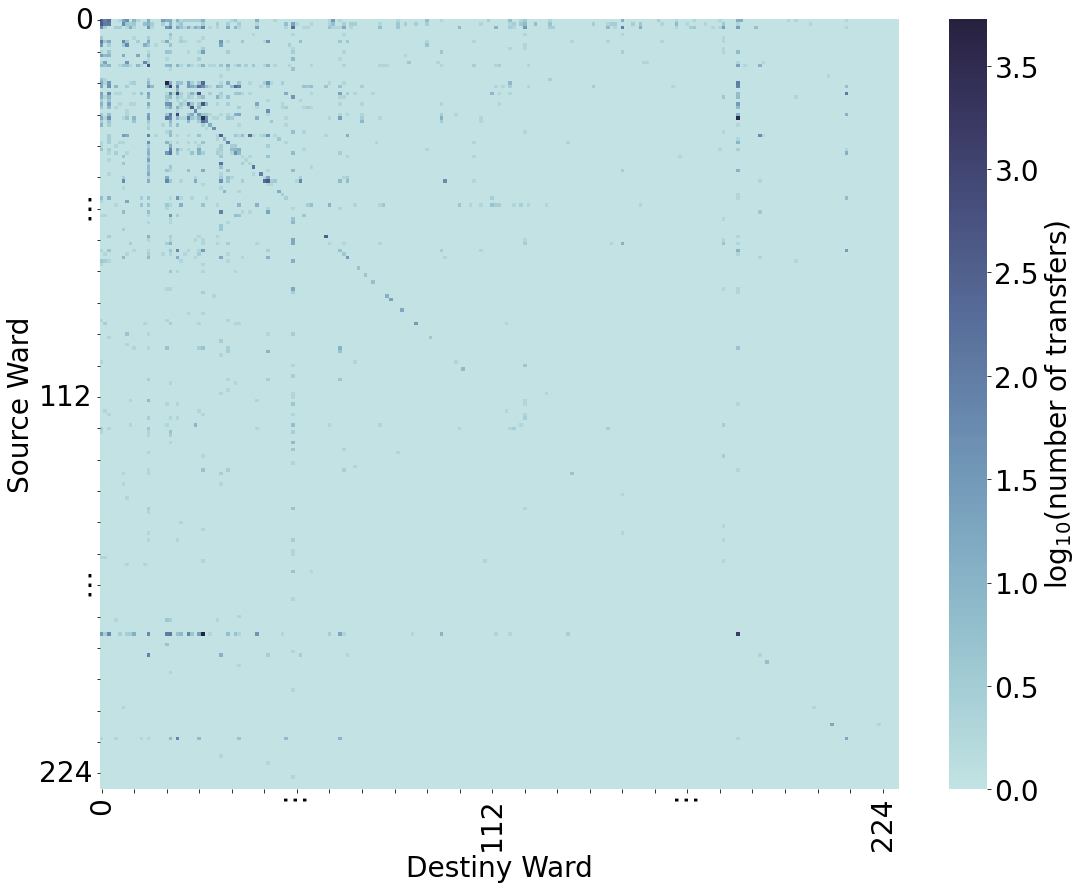

In [7]:
import seaborn as sns

fig_dims = figure_size_setting(1500)
fig_dims = [fig_dims[0], fig_dims[1]*1]


fig, ax = plt.subplots(1, 1, figsize=(16, 13))
g = sns.heatmap(np.log10(adjacency_df+1), ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(number of transfers)"})
ax.set_xlabel("Destiny Ward")
ax.set_ylabel("Source Ward")
plt.tight_layout()


x_tick_labels=['0','','','','','',r'$\vdots$','','','','','','112','','','','','',r'$\vdots$','','','','','','224']

g.set(yticklabels=x_tick_labels)
g.set(xticklabels=x_tick_labels)

# path_to_save  = os.path.join(path_to_ms_figs, "transfer_ward2ward_heatmap.png")
# fig.savefig(path_to_save, dpi=300, transparent=True)


In [8]:

#communities_df  = pd.read_csv('../abm_inference/data/communities_infomap.csv')#.drop(columns=["Unnamed: 0"])
communities_df  = pd.read_csv(os.path.join(path_to_data, "ward2cluster.csv"))
wardid2building = {row["ward_id"]: row["building"]  for idx, row in communities_df.iterrows()}

# Create adjacency matrix and networkx graph
adjacency_buildings_df = pd.DataFrame(index=np.unique(list(wardid2building.values())), columns=np.unique(list(wardid2building.values())))
adjacency_buildings_df = adjacency_buildings_df.fillna(0)

for idx, row in tqdm.tqdm(list_edges_df.iterrows()):
    ward1 = int(row["ward_1"])
    ward2 = int(row["ward_2"])

    adjacency_buildings_df.loc[wardid2building[ward1], wardid2building[ward2] ] += 1


communities_df["community"].iloc[np.where(communities_df["community"]>=6)[0]] = 6

wardid2communityID = {row["ward_id"]: row["community"]  for idx, row in communities_df.iterrows()}

# Create adjacency matrix and networkx graph
adjacency_communityIDs_df = pd.DataFrame(index=np.unique(list(wardid2communityID.values())), columns=np.unique(list(wardid2communityID.values())))
adjacency_communityIDs_df = adjacency_communityIDs_df.fillna(0)

for idx, row in tqdm.tqdm(list_edges_df.iterrows()):
    ward1 = int(row["ward_1"])
    ward2 = int(row["ward_2"])
    adjacency_communityIDs_df.loc[wardid2communityID[ward1], wardid2communityID[ward2] ] += 1



35524it [00:10, 3303.86it/s]
/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
35524it [00:11, 3092.24it/s]


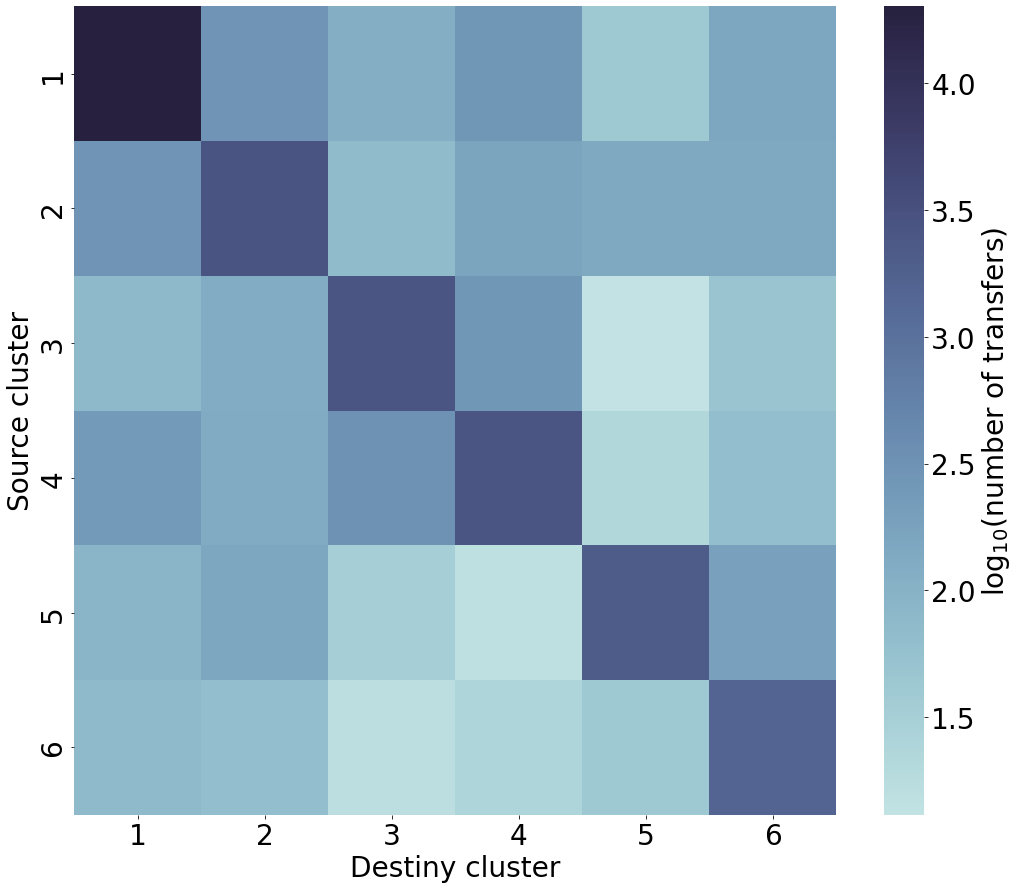

In [9]:
fig_dims = figure_size_setting(1500)
fig_dims = [fig_dims[0], fig_dims[1]*1]

#fig, ax = plt.subplots(1, 1, figsize=fig_dims)
fig, ax = plt.subplots(1, 1, figsize=(15, 13))

sns.heatmap(np.log10(adjacency_communityIDs_df+1), ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), cbar_kws={'label': r"$\log_{10}$(number of transfers)"})
ax.set_ylabel("Source cluster")
ax.set_xlabel("Destiny cluster")
plt.tight_layout()

#path_to_save  = os.path.join(path_to_ms_figs, "community_heatmap_transfers.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


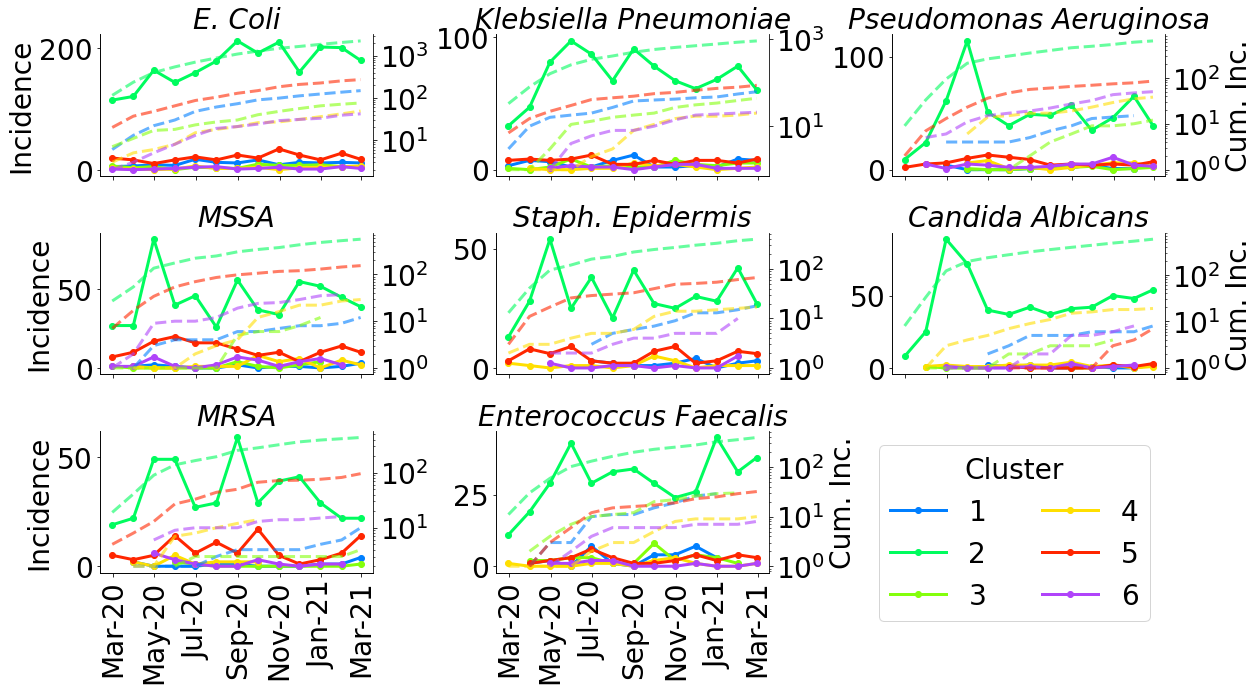

In [10]:
specimens_inference = ["ESCHERICHIA COLI", "KLEBSIELLA PNEUMONIAE", "PSEUDOMONAS AERUGINOSA", "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",
                        "STAPHYLOCOCCUS EPIDERMIDIS", "CANDIDA ALBICANS", "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS", "ENTEROCOCCUS FAECALIS"]

pathogen_time_df            = movement_df.copy().reset_index().groupby(["date", "cluster_id", "organism_name",  "specimen_group"]).sum()[["test"]].unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
pathogen_time_df            = pathogen_time_df[pathogen_time_df.organism_name.isin(specimens_inference)]
pathogen_time_df


clusters = [0, 1, 2, 3, 4, 5]

fig_dims = figure_size_setting(1500)
fig_dims = [fig_dims[0], fig_dims[1]*1]

fig, axes = plt.subplots(3, 3, figsize=(18.5, 11.5), sharex=True)
idx = 0

fig.delaxes(axes[-1, -1])

colors = sns.color_palette("gist_ncar", n_colors=6) #"ch:start=.2,rot=-1.1", n_colors=len(sites))

axes_t = []
for specimen in specimens_inference:
    ax      = axes.flatten()[idx]
    ax_t    = ax.twinx()

    ax.spines['top'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    axes_t.append(ax_t)
    format_axis(ax, week=False)

    sp_title = specimen
    if specimen == "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        sp_title = "MSSA"
    elif specimen == "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        sp_title = "MRSA"
    elif specimen == "STAPHYLOCOCCUS EPIDERMIDIS":
        sp_title = "Staph. Epidermis"
    elif sp_title == "ESCHERICHIA COLI":
        sp_title = "E. Coli"
    else:
        sp_title = " ".join([w.capitalize() for w in sp_title.lower().split(" ")])

    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.set_title(sp_title, fontstyle="italic")

    obs_df              = movement_df.copy()[movement_df.organism_name==specimen].reset_index()
    obs_df["positives"] = 1
    obs_df              = obs_df.groupby(["date", "cluster_id"]).sum()[["positives"]].reset_index()


    for idx_cluster, cluster in enumerate(clusters):
        obs_cluster_df = obs_df[obs_df.cluster_id==cluster]
        obs_cluster_df =  obs_cluster_df.set_index("date").resample("M").sum().reset_index()

        ax_t.plot(obs_cluster_df["date"], obs_cluster_df["positives"].cumsum(), linestyle="dashed", lw=3, alpha=0.6, label=cluster+1, c=colors[idx_cluster])
        ax.plot(obs_cluster_df["date"], obs_cluster_df["positives"], color=colors[idx_cluster], label=cluster+1, lw=3, marker='o')

        ax_t.set_yscale("log")
        #ax.scatter(obs_cluster_df["date"], obs_cluster_df["positives"], facecolor=colors[idx_cluster], label=cluster)
    idx += 1


x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Mar-21' ]

axes[1,0].set_xticks(x_ticks_pos, x_ticks_labels)

axes_t[2].set_ylabel("Cum. Inc.")
axes_t[5].set_ylabel("Cum. Inc.")
axes_t[7].set_ylabel("Cum. Inc.")

axes[0,0].set_ylabel(r"Incidence")
axes[1,0].set_ylabel(r"Incidence")
axes[2,0].set_ylabel(r"Incidence")

axes[-1,-2].legend(title="Cluster", bbox_to_anchor=(1.35, 1), ncol=2)

fig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.85, wspace=0.45, hspace=0.4)
#plt.tight_layout()
#path_to_save  = os.path.join(path_to_ms_figs, "clustered_observations.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


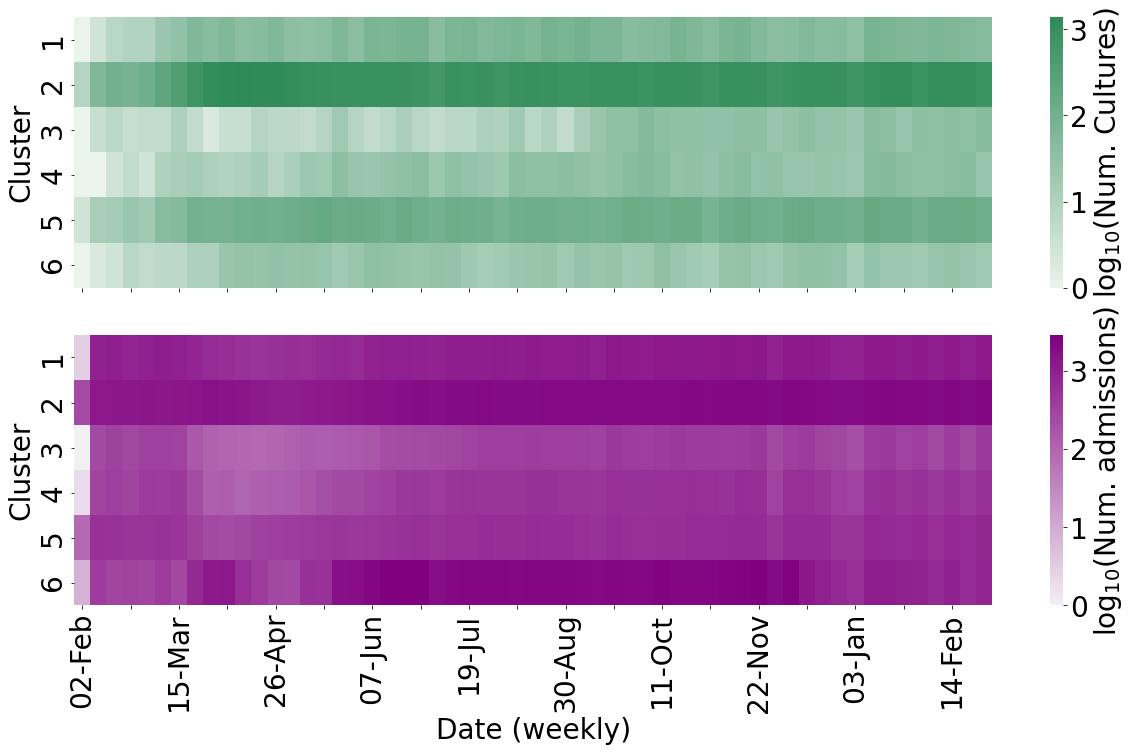

In [11]:
testing_per_ward_df = movement_df.copy(); testing_per_ward_df = testing_per_ward_df[testing_per_ward_df.test==1].reset_index()
testing_per_ward_df = testing_per_ward_df.groupby(["date", "cluster_id"]).sum().unstack(1).resample("W-Sun").sum().stack().reset_index()[["cluster_id", "date", "test"]]
testing_per_ward_df["cluster_id"] += 1

testing_per_ward_df["date_map"] = testing_per_ward_df["date"].map(lambda x: x.strftime('%d-%b'))
testing_mat_per_ward_df         = testing_per_ward_df.pivot(index="cluster_id", columns=["date_map"], values="test").fillna(0)

admissions_per_ward_df = movement_df.copy().reset_index().groupby(["date", "cluster_id"]).sum().reset_index()
admissions_per_ward_df = admissions_per_ward_df.set_index(["date", "cluster_id"]).unstack(1).resample("W-Sun").sum().stack().reset_index()
admissions_per_ward_df["cluster_id"] += 1

ward_test_df           = admissions_per_ward_df.reset_index().groupby("cluster_id").sum().reset_index().sort_values(by="first_day")
ward_order             = np.flip(ward_test_df["cluster_id"].values)

admissions_per_ward_df["date_map"] = admissions_per_ward_df["date"].map(lambda x: x.strftime('%d-%b'))
admissions_mat_per_ward_df         = admissions_per_ward_df.pivot(index="cluster_id", columns=["date_map"], values="first_day").fillna(0)


date_order = admissions_per_ward_df["date"].unique()
date_order = pd.DataFrame(date_order)[0].map(lambda x: x.strftime('%d-%b')).values

admissions_mat_per_ward_df = admissions_mat_per_ward_df[date_order]
testing_mat_per_ward_df = testing_mat_per_ward_df[date_order]

fig_dims = figure_size_setting(1600)

fig, ax = plt.subplots(2, 1, figsize=fig_dims, sharex=True, sharey=True)
sns.heatmap(ax=ax[0], data=np.log10(testing_mat_per_ward_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(Num. Cultures)"})
ax[0].set_xlabel(None)

sns.heatmap(ax=ax[1], data=np.log10(admissions_mat_per_ward_df+1), cmap=sns.light_palette("purple", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(Num. admissions)"})
ax[1].set_xlabel("Date (weekly)")
ax[0].set_ylabel("Cluster")
ax[1].set_ylabel("Cluster")
x_tick_labels=['02-Feb', '', '15-Mar', '', '26-Apr', '', '07-Jun', '', '19-Jul', '', '30-Aug', '', '11-Oct', '', '22-Nov', '', '03-Jan', '', '14-Feb']
ax[1].set_xticklabels(x_tick_labels)

plt.tight_layout()

#path_to_save  = os.path.join(path_to_ms_figs, "heatmaps_test_admission_clustered.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)
